In [2193]:
# required python libraries
import pandas as pd
import numpy as np
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt
import time

# scikit-learn models and functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector  # slow processing
from sklearn.feature_selection import RFE

# Logistic Regression Models
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import sys
# this_function_name = sys._getframe(  ).f_code.co_name

import warnings
warnings.filterwarnings('ignore')

week_no=3
adsi_file_name = f'paipa_carol-90014679-week{week_no}'
print('adsi_file_name =>',adsi_file_name)

adsi_file_name => paipa_carol-90014679-week3


In [2187]:
# import training & final test data
df_train = pd.read_csv('../data/processed/clean_train.csv')
df_test = pd.read_csv('../data/processed/clean_test.csv')

# Extract the column TARGET_5Yrs and save it into variable called target
target = df_train.pop('TARGET_5Yrs')

labels = df_train.columns.tolist() 
print(labels)

# original list for reference
# ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']
# ['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']

# copy original data
df_fix_train = df_train.copy()
df_fix_test = df_test.copy()

# check we have the Id column in the final Test (kaggle) data
df_test.head()

['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.300000,0.8
1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,-0.000000,1.8
2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.300000,2.0
3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.100000,3.6
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,0.389227,0.9


In [2188]:
# only keep selected features / cols
def select_features(df_train, df_test, keep_cols=['']):
    # take copies of the Cleaned data up to now - so we can rerun from here different feature selections
    df_clean_new = df_train.copy()
    df_clean_new_test = df_test.copy()
    
    return df_clean_new[keep_cols], df_clean_new_test[keep_cols]


# count negative values in each column
def plot_negative_values(df_neg, labels):

    # plotting a bar chart negative values
    neg_value = list(df_neg)
    
    plt.bar(np.arange(len(labels)), neg_value) # , color = ['red', 'green'])

    # naming the x-axis
    plt.xlabel('x - axis')
    plt.xticks(np.arange(len(labels)),labels=labels, rotation=45)
    # naming the y-axis
    plt.ylabel('y - axis')
    # plot title
    plt.title('Negative values')

    # function to show the plot
    plt.show(); 
   

In [2189]:
# count negative values in each column
def count_negative_values_alt(df_train, labels):
    # print(isinstance(df_train,np.ndarray))
    
    # check if dataframe or np.array - get the number of cols/dimensions
    len_train_col = np.size(df_train,1) if isinstance(df_train,np.ndarray) else len(df_train.columns)
    # print('len_train_col',len_train_col)
    
    df_neg = []
    neg_total = 0
    for i in range(len_train_col):
        if isinstance(df_train, np.ndarray):
            # training data is np.array
            neg_count = (np.sum(df_train[:,i]<=0, axis=0))
            df_neg.append(neg_count)
            neg_total+=neg_count
            #print('np.sum',neg_count)
            #print('i',i, df_neg ) #np.sum(np.array(df_train[:,1]), axis=0)) #, 'df_neg[i]', df_neg[i])
        else:
            # training data is dataframe with labels
            #print('labels[i]',[df_train[df_train[labels[i]]<0][labels[i]].count()])
            neg_count = df_train[df_train[labels[i]]<0][labels[i]].count()
            df_neg.append(neg_count)
            neg_total+=neg_count
            # print('i',i, df_neg[labels[i]] ) #, 'df_neg[i]', df_neg[i])
      
    # only show chart if there are negative values
    if (np.sum(list(df_neg), axis=0))==0:
        print('No negative values found - nothing to graph')
    
    else:
        # print('Total neg val',neg_total,df_neg)
        plot_negative_values(df_neg, labels)
    
    return df_neg

# TESTING ONLY
# print(X_train)  
# print(X_train[:,0])  

# Testing np.array format
# df_neg = count_negative_values_alt(X_train, labels)   

# Testing dataframe format
# count_negative_values_alt(df_fix_train, labels)  

In [2162]:
df_train[df_train['GP']<19].sort_values(['GP'], ascending=True).head(10)

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
5323,-8,5.8,1.5,0.6,1.9,33.6,0.0,0.2,13.9,0.1,0.2,63.6,0.0,0.5,0.6,0.2,0.1,-0.5,0.3
7400,-3,6.1,2.1,0.8,1.9,39.1,-0.2,-0.5,19.2,0.6,0.9,70.2,0.6,0.4,0.8,0.1,0.3,0.1,0.4
6450,1,5.0,1.2,0.5,1.2,42.2,0.1,0.1,11.9,0.2,0.3,58.0,0.1,0.3,0.4,0.4,0.3,-0.1,0.3
3093,3,8.3,2.0,0.8,2.2,35.0,0.2,0.8,18.6,0.4,0.9,38.9,0.4,0.9,1.4,0.5,0.3,0.2,0.3
2763,4,3.8,0.9,0.3,1.0,33.5,0.1,0.2,29.0,0.1,0.1,76.5,0.0,0.3,0.4,0.1,0.1,0.1,0.1
5008,6,5.7,1.2,0.5,1.3,41.5,0.3,1.3,8.0,0.1,0.1,65.6,0.0,0.4,0.5,0.3,0.1,0.1,0.3
4598,8,5.1,1.5,0.7,2.0,36.1,0.2,1.0,11.0,0.1,0.1,67.2,0.1,0.4,0.5,0.1,0.1,-0.1,0.2
7847,8,6.4,1.5,0.5,1.5,38.8,-0.1,-0.1,20.2,0.3,0.5,68.5,0.2,0.4,0.7,0.5,0.3,-0.1,0.3
7871,10,5.5,1.8,0.6,1.5,43.2,0.3,0.9,11.2,0.3,0.5,63.0,0.2,0.4,0.7,0.4,0.1,-0.1,0.4
7671,10,14.8,4.0,1.5,3.7,40.5,0.6,1.7,31.6,0.6,0.9,66.0,0.6,1.5,2.2,0.6,0.4,0.2,0.7


In [2190]:
# count negative values in each column
df_neg = pd.DataFrame()
for i in range(len(df_train.columns)):
    df_neg[labels[i]] = [df_train[df_train[labels[i]]<0][labels[i]].count()]  
    
df_neg_test = pd.DataFrame()
for i in range(len(df_test.columns)):
    df_neg_test[labels[i]] = [df_test[df_test[labels[i]]<0][labels[i]].count()]  

print('Training data - negative values')
display(df_neg)

count_negative_values_alt(df_fix_train, labels)

print('Final Testing data - negative values')
display(df_neg_test)

count_negative_values_alt(df_fix_test, labels)

Training data - negative values


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No negative values found - nothing to graph
Final Testing data - negative values


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No negative values found - nothing to graph


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [1589]:
# check out negative GP
print('Negative values - GP')
display(df_fix_train[df_fix_train['GP']<=0])

Negative values - GP


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
5323,-8,5.8,1.5,0.6,1.9,33.6,0.0,0.2,13.9,0.1,0.2,63.6,0.0,0.5,0.6,0.2,0.1,-0.5,0.3
7400,-3,6.1,2.1,0.8,1.9,39.1,-0.2,-0.5,19.2,0.6,0.9,70.2,0.6,0.4,0.8,0.1,0.3,0.1,0.4


In [670]:
# BLK negative = 1048 rows
print('Negative values - BLK')
display(df_fix_test.loc[(df_fix_test['BLK']<0)][0:5])

Negative values - BLK


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
7,53,12.1,4.7,1.8,4.1,44.1,0.1,0.2,25.7,0.9,1.0,80.2,0.6,1.1,1.6,0.8,0.4,-0.2,0.6
30,63,19.5,10.7,4.5,9.2,49.1,0.8,2.2,44.4,1.1,1.3,83.0,0.3,1.1,1.4,3.4,1.0,-0.5,1.6
81,68,14.8,6.8,2.7,5.2,50.9,0.4,0.9,37.3,1.2,1.5,84.0,0.8,1.3,2.2,1.1,0.3,-0.3,0.9
83,47,10.9,4.5,1.8,3.9,43.5,0.5,1.5,36.5,0.9,1.3,70.4,0.5,0.7,1.3,0.8,0.5,-1.0,0.8


In [671]:
# 3P Made negative = 1629 rows
print('Negative values - 3P Made')
display(df_fix_test.loc[(df_fix_test['3P Made']<0)][0:5])

Negative values - 3P Made


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
5,59,16.1,7.1,2.8,4.5,62.0,-0.1,-0.6,3.4,1.7,2.7,58.6,1.8,2.6,4.6,0.6,0.6,0.4,0.9
6,45,8.3,3.2,1.4,2.8,46.4,-0.5,-1.6,8.9,0.5,0.7,69.3,0.5,0.5,1.2,0.2,0.1,0.2,0.4
16,78,23.9,8.1,3.1,5.8,52.1,-0.1,-0.1,33.8,2.1,3.2,64.3,1.4,2.3,3.7,1.4,0.6,0.3,1.8
18,27,8.5,1.6,0.7,1.4,50.4,-0.2,-0.6,22.4,0.1,0.2,55.8,0.6,1.1,1.5,0.4,0.3,0.0,0.4
21,59,35.0,20.5,8.7,14.8,62.3,-0.5,-1.4,0.0,4.2,6.0,69.2,6.9,7.2,13.8,0.9,1.5,3.5,2.4


In [2191]:
# calculate mean for cols with negative values - update those values with the mean
df_fix_train = df_train.copy()
df_fix_test = df_test.copy()

def fix_negative_values(df_fix, df_neg_count, show=False, fix=False, title=''):
    if title!='':
        print(title)
        
    df_neg_fix = df_fix.copy()
    for i in range(len(df_neg_count.columns)):
        neg_val = int(df_neg_count.iloc[:,i].values)
        if neg_val>0:
            mean_val = df_neg_fix[labels[i]].loc[(df_neg_fix[labels[i]]>0)].mode()
            if show==True:
                print(labels[i],mean_val)

            if fix==True:
                # update negative values with the mean for that column
                df_neg_fix[labels[i]].loc[(df_neg_fix[labels[i]]<0)]=mean_val
                
    return df_neg_fix

# TESTING 
# fix_negative_values(df_fix_train, df_neg, True, False, 'Training data negative cols - mean') 
# print('')
# fix_negative_values(df_fix_test, df_neg_test, True, False, 'Test data negative cols - mean') 
# print('')

In [2192]:
print('before fix 3PA:',list(df_fix_train['3PA'].loc[(df_fix_train['3PA']<0)])[0:20])
print('before fix BLK:',list(df_fix_train['BLK'].loc[(df_fix_train['BLK']<0)])[0:20])

count_negative_values_alt(df_fix_train, labels)
count_negative_values_alt(df_fix_test, labels)

# set negative values to the mean
df_fix_train = fix_negative_values(df_fix_train, df_neg, False, True, '')  
df_fix_test = fix_negative_values(df_fix_test, df_neg_test, False, True, '')  

print('\nafter fix 3PA :',df_fix_test['3PA'].loc[(df_fix_test['3PA']<0)])
print('after fix BLK :',df_fix_test['BLK'].loc[(df_fix_test['BLK']<0)],'\n')

count_negative_values_alt(df_fix_train, labels)
count_negative_values_alt(df_fix_test, labels)

before fix 3PA: []
before fix BLK: []
No negative values found - nothing to graph
No negative values found - nothing to graph

after fix 3PA : Series([], Name: 3PA, dtype: float64)
after fix BLK : Series([], Name: BLK, dtype: float64) 

No negative values found - nothing to graph
No negative values found - nothing to graph


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [1871]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

# set defaults
random_state=100
scaler = StandardScaler()

# Prepare training data for modelling - Standardising, Resampling for imbalanced data
def Prep_Model_Data(df_clean, target, scaler='', resample='', random_state=8):
    features_no = len(df_clean.columns)
    
    # rescale eg: scaler = StandardScaler()
    if scaler!='':
        df_clean = scaler.fit_transform(df_clean)

    #---------------------------------------------------------------------------------------
    # Split randomly the dataset with random_state=8 into 2 different sets: data (80%) and test (20%)
    X_data, X_test, y_data, y_test = train_test_split(df_clean, target, test_size=0.2, random_state=random_state)

    # Split the remaining data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state) 
    
    #---------------------------------------------------------------------------------------
    # RESAMPLE if indicated
    
    # Original Training data
    if resample=='NO RESAMPLE' or resample=='':
        X_train_res, y_train_res = X_train, y_train
        X_val_res, y_val_res =  X_val, y_val
        X_test_res, y_test_res =  X_test, y_test
        #print(resample,'NO Resample -',features_no,'Features')
    
    # SMOTE - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='SMOTE':
        X_train_res, y_train_res = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = SMOTE(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = SMOTE(random_state=random_state).fit_resample(X_test, y_test)
        #print(resample,'Resample -',features_no,'Features')

    # ADASYN - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='ADASYN':
        X_train_res, y_train_res = ADASYN(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = ADASYN(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = ADASYN(random_state=random_state).fit_resample(X_test, y_test)
       
    return X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res

In [1821]:
from sklearn.metrics import roc_auc_score, make_scorer

def Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, classifier, features='all', resample='resample'):
    t_start = time.process_time()
    # fit model
    classify = classifier.fit(X_train_res, y_train_res)
    t_end = time.process_time()       
    t_diff = t_end - t_start

    #--------------------------------------------------------------------------
    # Compare accuracy of the given test data
    
    # baseline target average
    y_mode = y_train_res.mode()
    
    if resample=='NO RESAMPLE' or resample=='':
        y_base_res = np.full((len(y_train_res), 1), y_mode)
    else: 
        y_base_res = np.full((len(y_train_res), 1), y_mode[0])

    # for debugging during dev/test
    if 1==2:
        print('mode',y_train_res.mode(), '\ttype:',type(y_train_res.mode()))
        print('len(X_train)',len(X_train_res))
        print('len(y_train)',len(y_train_res))
        print('y_base_res',y_base_res)

    #--------------------------------------------------------------------------
    # final test (unseen) data AUC score
    pred_prob = classifier.predict_proba(X_test_res)
    auc_score = roc_auc_score(y_test_res, pred_prob[:,1])
    
    # simple print of accuracy scores
    if 1==2:
        print(f"Compare accuracy between data sets - testing {features} features ")
        print(f"Classifier - {classify}")
        print(f"Imbalanced data fix - {resample}")
        print("Baseline:     ",accuracy_score(y_train_res, y_base_res))
        print("Train data:   ",classifier.score(X_train_res, y_train_res))
        print("Validation:   ",classifier.score(X_val_res, y_val_res))
        print('Test data auc:',auc_score,'\n')    
    
    clf_str = f'{classify}'
    clf_n = clf_str.find('(')
    
    df_scores = []
    df_scores.append((clf_str[0:clf_n], 'None' if resample=='' else resample, X_train_res.ndim,
                 accuracy_score(y_train_res, y_base_res), 
                 classifier.score(X_train_res, y_train_res),
                 classifier.score(X_val_res, y_val_res),
                 roc_auc_score(y_test_res, pred_prob[:,1]) ))
    
    return classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, df_scores


In [384]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# MLPClassifier parameters
activation='logistic'
solver='adam'     # sgd, adam (default)
alpha=0.01        # 0.0001 default
max_iter=300
batch_size=100    

random_state=100

# Classification Models defined - MLPClassifier()
clf_NN_MLP=MLPClassifier(activation=activation, solver=solver, alpha=alpha, batch_size=batch_size, random_state=random_state)

# Classification Models defined - LogisticRegression()
clf_LR=LogisticRegression(C=109.85411419875572, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100, n_jobs=None, penalty='l2',
          tol=0.0001, verbose=0, warm_start=False, random_state=random_state)

SelectFromModel(estimator=LogisticRegression(), max_features=3)
Index(['PTS', 'FGA', 'OREB'], dtype='object')
Time taken: 0.8314798589999555


In [701]:
# 3. Recursive Feature Elimination (RFE)
# https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172
from sklearn.feature_selection import RFE

t_start = time.process_time()

# Selecting the Best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select=6, step=1)
rfe_selector.fit(df_fix_train, target)

print(rfe_selector)

top_feat_rfe = df_fix_train.columns[rfe_selector.get_support()]
print(top_feat_rfe)

print('Time taken:', round((time.process_time()-t_start),2))


RFE(estimator=LogisticRegression(), n_features_to_select=6)
Index(['FGM', 'FGA', 'FTM', 'OREB', 'DREB', 'REB'], dtype='object')
Time taken: 8.99


In [ ]:
dict_feature_select = {
    'SelectFromModel': SelectFromModel(estimator=LogisticRegression(), max_features=max_features)
    'RFE': RFE(estimator=LogisticRegression(),n_features_to_select=max_features, step=1)
    'SequentialFeatureSelectorBack': SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=3, cv=5, direction ='backward')
    'SequentialFeatureSelectorFwd': SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=3, cv=5, direction ='forward')
}

In [2078]:
dict_classifiers = {
    "LogisticRegression": LogisticRegression(random_state=random_state),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=random_state),
    "ComplementNB": ComplementNB(),
}

    #"Neural Net": MLPClassifier(alpha = 1,random_state=random_state),

dict_scaler = {
    'StandardScaler': StandardScaler(),
    'Normalizer': Normalizer(),
}

#     'Standard': StandardScaler(),
#     'MinMaxScaler': MinMaxScaler(),
#     'RobustScaler': RobustScaler()

dict_resample = {
    'None'  : '',
    'SMOTE' : 'SMOTE',
    'ADASYN': 'ADASYN'
}


In [1835]:
# Get the selected columns from SelectModel (etc ...) where the results are ONLY the remaining columns NO headings
def get_selected_columns(X_train, top_feat, labels, show_compare=False):
    df_before = pd.DataFrame(X_train,columns=[labels])[0:1] 
    df_after = pd.DataFrame(top_feat)[0:1] 

    if show_compare:
        print(f'\nCompare feature columns before {df_before.size} features')
        display(df_before)

    i_after = 0
    df_cols_after = []
    
    # iterate through before columns, compare to each after column
    for i in range(np.size(X_train,1)):
        
        # stop when it's the end of the selected features
        if i_after < np.size(top_feat,1):
            test_bf = str(df_before.iloc[0,i])
            test_af = str(df_after.iloc[0,i_after])

            # when both before & after values match - keep 
            if test_bf==test_af:
                df_cols_after.append(labels[i])
                i_after+=1
    
    if show_compare:
        print(f'Compare feature columns after {df_after.size} features')
        df_after.columns=df_cols_after
        display(df_after)
        
    return df_cols_after

In [1905]:
def select_features_auto(X_train, y_train, feature_selector, no_select_feat=2, estimator=None, max_features=3, step=1, cv=5, direction='forward'):
    t_start = time.process_time()
    # print(f'Feature Selection - {feature_selector} - {max_features}')
    
    # define here to parameters are dynamic - max_features=max_features, n_features_to_select=max_features, 
    dict_feature_select = {
        'SFM': SelectFromModel(estimator=estimator, prefit=False),
        'RFE': RFE(estimator=estimator,step=step),
        'SFSB': SequentialFeatureSelector(estimator=estimator, n_features_to_select=3, cv=5, direction ='backward'),
        'SFSF': SequentialFeatureSelector(estimator=estimator, n_features_to_select=3, cv=5, direction ='forward')
    }  
    
    # Selecting the Best important features according to Logistic Regression
    # fs_selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=max_features, cv=cv, direction=direction)
    fs_selector = dict_feature_select.get(feature_selector)
    fs_selector.fit(X_train, y_train)
    # print('\n',fs_selector)
    
    X_train_fs = fs_selector.transform(X_train)
    # when Classifiers don't have 'get_support()' - then call this
    top_feat_fs = get_selected_columns(X_train, X_train_fs, labels, show_compare=False)
        
    #print('Time taken:', round((time.process_time()-t_start),2),'seconds')
    return top_feat_fs

In [2112]:
def batch_classify(X_train, Y_train, X_test, Y_test, X_val, Y_val, X_final, classifier_name, 
                   scaler=scaler, resample='', test_no=1, scale_no=1, sample_no=1, top_feat=None, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    t_start = time.process_time()
    
    classifier = dict_classifiers[classifier_name]
    # fit model
    classifier.fit(X_train, Y_train)
    
    t_end = time.process_time()       
    t_diff = t_end - t_start

    #--------------------------------------------------------------------------
    # Save the predictions from this model for the training and validation sets, and the final "test" set 
    y_train_preds = classifier.predict(X_train)
    y_val_preds = classifier.predict(X_val)

    #save the final "test" prediction probabilities for Kaggle
    y_final_preds = classifier.predict_proba(X_final)

    # baseline target average
    y_mode = y_train_res.mode()

    if resample=='NO RESAMPLE' or resample=='':
        y_base = np.full((len(Y_train), 1), y_mode)
    else: 
        y_base = np.full((len(Y_train), 1), y_mode[0])

    #--------------------------------------------------------------------------
    # classifier scores - training, test & validation data
    baseline = accuracy_score(Y_train, y_base)
    train_score = classifier.score(X_train, Y_train)
    val_score = classifier.score(X_val, Y_val)
    test_score = classifier.score(X_test, Y_test)

    # predict probabilities
    pred_prob = classifier.predict_proba(X_test) 
    # auc scores
    auc_score = roc_auc_score(Y_test, pred_prob[:,1])

    dict_models={}
    dict_models[classifier_name] = {'model'      : classifier,         'test_num'    : f'Test {test_no}-{scale_no}-{sample_no}',  
                                    'transform'  : scaler,             'resample'    : 'None' if resample=='' else resample, 
                                    'features'   : np.size(X_train,1), 'train_score' : train_score, 
                                    'val_score'  : val_score,          'test_score'  : test_score,    
                                    'auc_score'  : auc_score,          'train_time'  : t_diff ,
                                    'top_feat'   : top_feat
                                   }

    # print('dict_models',dict_models)
    #--------------------------------------------------------------------------
    # parameters for saved file names

    class_name = classifier_name
    scale_name = dict_models[classifier_name].get('transform')
    scale_name = str(scale_name)
    scale_name = re.sub('\\(\\)','',scale_name)
    resam_name = 'None' if resample=='' else resample
        
    #--------------------------------------------------------------------------
    # Save the fitted model into the folder 'models', named for each classifier
    # print('save model => ../models/{a}_{c}_{s}_{r}.joblib'.format(a=adsi_file_name, c=class_name, s=scale_name, r=resam_name))
    dump(classifier,  '../models/{a}_{c}_{s}_{r}.joblib'.format(a=adsi_file_name, c=class_name, s=scale_name, r=resam_name))
    #--------------------------------------------------------------------------

    if verbose:
        print("trained {s}, {r}, {c} - in {f:.2f} s\tauc: {a:.3f} \n".format(c=classifier_name, r='None' if resample=='' else resample, s=scaler, f=t_diff,a=auc_score))
           
    return dict_models


In [2107]:
def batch_stand_norm_data(df_fix_train, df_fix_test, target, classifier_name, no_classifiers=1, scaler_no=1, resample_no=1, test_no=1, random_state=random_state, show_results=True, verbose=True):
    # loop counters - test (scaler), resample
    scale_no=0
    top_feat = pd.DataFrame()
    print(f'Training test-{test_no} {classifier_name}')
    
    # best scores definition: best_auc, best_mape, best_pred, best_year = float("inf"), float("inf"), None, None
    best_test, best_clf, best_auc, best_feat, best_resample, best_transform = None, None, float("inf"), None, None, None
    
    df_overall = pd.DataFrame(columns=test_sum_cols)

    # iterate through - dict_scaler - StandardScaler, Normalizer, RobustScaler (tbc)
    for scaler_name, scaler in list(dict_scaler.items())[:scaler_no]:
        
        scale_no+=1    # increment each loop
        sample_no=0    # reset each loop
        results = pd.DataFrame(columns = test_sum_cols)
        
        # iterate through - dict_resample - None, SMOTE, ADASYN
        for resample_name, resample in list(dict_resample.items())[:resample_no]:

            sample_no+=1   # increment each loop
            df_scores = []
            
            # prepare data same as for modelling - labels = all features
            df_clean_mod, df_clean_mod_test = select_features(df_fix_train, df_fix_test, labels)
            # Prepare Train/Val/Test data - for select_features_auto()
            X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_mod, target, scaler=scaler, resample=resample, random_state=random_state)

            # Run SelectModel Feature Selection for the each Classifier - as they return different number of features
            estimator = dict_classifiers[classifier_name]
            top_feat = select_features_auto(X_train, y_train, feature_selector='SFM', no_select_feat=2, estimator=estimator, max_features=i, step=1, cv=5, direction='forward')

            # intiailse training data for this test - using top features from select_features_auto() step
            df_clean_mod, df_clean_mod_test = select_features(df_fix_train, df_fix_test, top_feat)
            
            # Prepare Train/Val/Test data - for modelling - batch_classify()
            X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_mod, target, scaler=scaler, resample=resample, random_state=random_state)

            # run multiple classfication models
            dict_models = {}
            dict_models = batch_classify(X_train, y_train, X_val, y_val, X_test, y_test, df_clean_mod_test, classifier_name, 
                                         scaler, resample, test_no, scale_no, sample_no, top_feat, verbose)

            # display performance results - accuracy scores
            df_scores = display_dict_models(dict_models, y_test, sort_by, test_no, False)

            # convert scores to a DataFrame
            results = results.append(df_scores)
            # print(f'results sample scale-sample {test_no}-{scale_no}-{sample_no}')
            # display(results)     
                
        # only keep best overall result for the Business Unit
        # results_sort = results.sort_values(by=['auc_score'])[0:1]
        df_overall = df_overall.append(results)
        # print(f'df_overall     scale-sample {test_no}-{scale_no}-{sample_no}')
        # display(df_overall)

    #print(f'batch_stand_norm_data test {test_no}-{scale_no}-{sample_no}')
    return df_overall

In [2123]:
def display_dict_models(dict_models, Y_test, sort_by='auc_score', test_no_class=1, show_results=False):
    cls = [key for key in dict_models.keys()]
    test_num = [dict_models[key]['test_num'] for key in cls]
    features = [dict_models[key]['features'] for key in cls]
    resample = [dict_models[key]['resample'] for key in cls]
    scaler = [dict_models[key]['transform'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    val_s = [dict_models[key]['val_score'] for key in cls]
    test_s = [dict_models[key]['test_score'] for key in cls]
    roc_auc = [dict_models[key]['auc_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    top_features = [dict_models[key]['top_feat'] for key in cls]
    top_features = ''.join(map(str, top_features))
    
    # print(f'display_dict_models top_features', top_features)
    
    # setup output dataframe
    # columns = ['test_no','classifier','features','transform','resample','train_score','val_score','test_score','auc_score','train_time','top_feat']
    # df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),len(columns))), columns = columns)
    df_ = pd.DataFrame(data=np.zeros(shape=(1,len(test_sum_cols))), columns = test_sum_cols)
    
    df_scores = []
    best_test, best_clf, best_auc, best_feat, best_resample, best_transform = None, None, float("inf"), None, None, None
    
    ii = 0 #test_no_class-1
    
    #for ii in range(0,len(cls)):
    #print(f'display_dict_models loop {ii}')
    df_.loc[ii, 'classifier'] = cls[ii]
    df_.loc[ii, 'test_no'] = test_num[ii]
    df_.loc[ii, 'features'] = features[ii]
    df_.loc[ii, 'transform'] = scaler[ii]
    df_.loc[ii, 'resample'] = resample[ii]
    df_.loc[ii, 'train_score'] = training_s[ii]
    df_.loc[ii, 'val_score'] = val_s[ii]
    df_.loc[ii, 'test_score'] = test_s[ii]
    df_.loc[ii, 'auc_score'] = roc_auc[ii]
    df_.loc[ii, 'train_time'] = training_t[ii]
    df_.loc[ii, 'top_feat'] = top_features
    
    df_scores = df_.sort_values(by='test_no', ascending=False)
    
    if show_results:
        print('\n')
        display(df_.sort_values(by=sort_by, ascending=False))
        
    return df_scores

In [2124]:
sort_by='auc_score'
show_results=False
verbose=False
resample=''
step=3
rerun_no=1
scaler_no=len(dict_scaler)
resample_no=len(dict_resample)
no_classifiers = 2  
#len(dict_classifiers)
# estimater = dict_classifiers.get('AdaBoost')
# StandardScaler(), Normalizer()
scaler=StandardScaler()

t_start = time.process_time()

# final test summary cols
test_sum_cols = ['test_no','classifier','features','transform','resample','train_score','val_score','test_score','auc_score','train_time','top_feat']
df_best = pd.DataFrame(columns = test_sum_cols)

test_no=0

for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
    test_no+=1
    df_scores = []

    # for each classifier - test per Scaler, and per Resample approach
    df_scores = batch_stand_norm_data(df_fix_train, df_fix_test, target, classifier_name, no_classifiers, scaler_no, resample_no, test_no, random_state, show_results=False, verbose=False)
    df_best = df_best.append(df_scores)

# show top 3 model results
print('Final results')
display(df_best.sort_values(by=sort_by, ascending=False)[0:3])
   
print('Time taken:', round((time.process_time()-t_start),2),'seconds\n')

Training test-1 LogisticRegression
Training test-2 AdaBoostClassifier
Final results


,test_no,classifier,features,transform,resample,train_score,val_score,test_score,auc_score,train_time,top_feat
0,Test 2-1-3,AdaBoostClassifier,4.0,StandardScaler(),ADASYN,0.749642,0.741509,0.717925,0.809373,0.216546,"['GP', '3P Made', 'STL', 'BLK']"
0,Test 2-1-2,AdaBoostClassifier,3.0,StandardScaler(),SMOTE,0.733809,0.713964,0.702358,0.789729,0.196342,"['GP', '3P Made', 'BLK']"
0,Test 2-2-3,AdaBoostClassifier,9.0,Normalizer(),ADASYN,0.702432,0.657756,0.624537,0.685194,0.586768,"['GP', 'FGM', 'FGA', 'FG%', '3P Made', 'FT%', ..."


Time taken: 22.19 seconds



In [2185]:
from joblib import load 
from re import search

# Final Kaggle Test data - Id column - to align with our final results
test_id = pd.read_csv('../data/raw/test.csv')
test_id = test_id['Id']

#----------------------------------------------------------------------------------------------------------------------------
df_kaggle = df_best.sort_values(by=sort_by, ascending=False)[0:1]     
display(df_kaggle)

# file name parameters
class_name = df_kaggle['classifier']
class_name = str(class_name[0])

scale_name = df_kaggle['transform']
scale_name = str(scale_name[0])
# remove spaces & ()
scale_name = re.sub(' ','',re.sub('\\(\\)','',str(scale_name)))

resam_name = df_kaggle['resample'].astype(str)
resam_name = resam_name[0]

top_feat = df_kaggle['top_feat'][0]
top_feat = top_feat[1:]
top_feat = top_feat[:-1]
top_feat = re.sub('\'','',top_feat)
top_feat = re.sub(', ',',',top_feat)
top_feat = top_feat.split(',')

best_name = f'{adsi_file_name}_{class_name}_{scale_name}_{resam_name}'
print('best filename => ', best_name)

#----------------------------------------------------------------------------------------------------------------------------
# Load the best model & fit to the Kaggle data
best_model = load('../models/{f}.joblib'.format(f=file_name))

#----------------------------------------------------------------------------------------------------------------------------
# intiailse training data for this test - using top features from select_features_auto() step
df_clean_mod, X_final = select_features(df_fix_train, df_fix_test, top_feat)

scaler=dict_scaler[scale_name]
X_final=scaler.fit_transform(X_final)

# predict probabilities
y_final_preds = best_model.predict_proba(X_final) 

# combine final "test" Id column with prediction probabilities column (cover to dataframe first) 
frames = [test_id, pd.DataFrame(y_final_preds[:,1])]
result = pd.concat(frames, axis=1) 

result.columns = ['Id','tmp']
result['TARGET_5Yrs'] = [round(num, 3) for num in result['tmp']]
result.drop(['tmp'], axis=1, inplace=True)

print('\nresult unseen kaggle test data')
display(result)

#--------------------------------------------------------------------------
# Save the final predictions for submission to Kaggle
result.to_csv('../data/processed/{f}.csv'.format(f=best_name), index=False)
#--------------------------------------------------------------------------


,test_no,classifier,features,transform,resample,train_score,val_score,test_score,auc_score,train_time,top_feat
0,Test 2-1-3,AdaBoostClassifier,4.0,StandardScaler(),ADASYN,0.749642,0.741509,0.717925,0.809373,0.216546,"['GP', '3P Made', 'STL', 'BLK']"


best filename =>  paipa_carol-90014679-week3_AdaBoostClassifier_StandardScaler_ADASYN

result unseen kaggle test data


,Id,TARGET_5Yrs
0,1,0.491
1,8194,0.498
2,3,0.498
3,8196,0.492
4,8197,0.502
...,...,...
3794,8175,0.495
3795,8176,0.501
3796,8178,0.488
3797,8181,0.498


In [ ]:
def save_kaggle_output(df_kaggle, X_train, Y_train, X_final, test_no):

    #--------------------------------------------------------------------------
    # parameters for saved file names

    class_name = df_kaggle['classifier']
    class_name = str(class_name[0])
    
    scale_name = df_kaggle['transform']
    scale_name = str(scale_name[0])
    # remove spaces & ()
    scale_name = re.sub(' ','',re.sub('\\(\\)','',str(scale_name)))
 
    resam_name = df_kaggle['resample'].astype(str)
    resam_name = resam_name[0]

    print('best model => ../models/{a}_{c}_{s}_{r}.joblib'.format(a=adsi_file_name, c=class_name, s=scale_name, r=resam_name))

    
# rank the features by their scores
def rank_features(title, labels, f_selector):
    pd_feat = pd.DataFrame(labels)
    pd_score = pd.DataFrame(f_selector) 

    pd_feat = pd.concat([pd_feat, pd_score],axis=1)
    pd_feat.columns=['feature','score']

    print(title)    
    return pd_feat.sort_values(by='score', ascending=False)

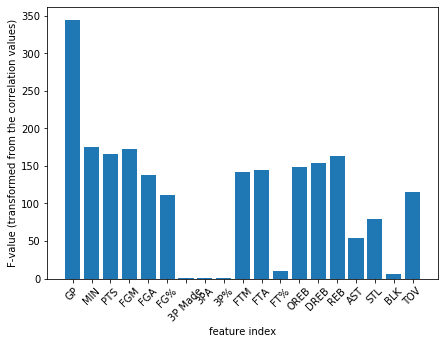

In [1028]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

df_clean_mod, df_clean_mod_test = select_features(df_fix_train, df_fix_test, labels)
X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_mod, target, scaler=StandardScaler(), resample='', random_state=random_state)

# feature selection
f_selector = SelectKBest(score_func=f_regression, k='all')

# learn relationship from training data
f_selector.fit(X_train, y_train)

# transform train input data
X_train_fs = f_selector.transform(X_train)

# transform test input data
X_test_fs = f_selector.transform(X_test)

# Plot the scores for the features
plt.rcParams["figure.figsize"] = (7,5) 
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xticks(np.arange(len(labels)),labels=labels, rotation=45)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()

In [1029]:
rank_features('Feature ranking by Regress scores', labels, f_selector.scores_)[0:10]

Feature ranking by MI Regress scores


,feature,score
0,GP,344.991066
1,MIN,174.975012
3,FGM,172.102495
2,PTS,166.508197
14,REB,162.815264
13,DREB,153.431741
12,OREB,148.168069
10,FTA,144.747089
9,FTM,142.009820
4,FGA,137.569614


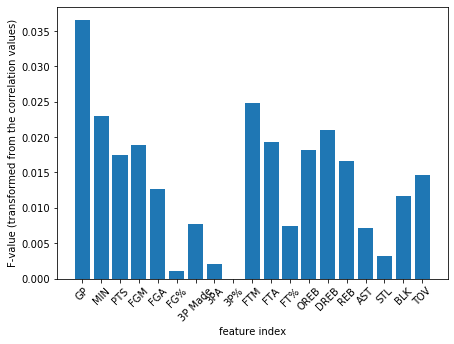

In [1023]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

df_clean_mod, df_clean_mod_test = select_features(df_fix_train, df_fix_test, labels)
X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_mod, target, scaler=StandardScaler(), resample='', random_state=random_state)

# feature selection
f_selector = SelectKBest(score_func=mutual_info_classif, k='all')

# learn relationship from training data
f_selector.fit(X_train, y_train)

# transform train input data
X_train_fs = f_selector.transform(X_train)

# transform test input data
X_test_fs = f_selector.transform(X_test)

# Plot the scores for the features
plt.rcParams["figure.figsize"] = (7,5) 
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xticks(np.arange(len(labels)),labels=labels, rotation=45)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()

In [1024]:
rank_features('Feature ranking by MI Classification scores', labels, f_selector.scores_)[0:10]

Feature ranking by MI Regress scores


,feature,score
0,GP,0.036630
9,FTM,0.024852
1,MIN,0.023032
13,DREB,0.020998
10,FTA,0.019251
3,FGM,0.018944
12,OREB,0.018201
2,PTS,0.017483
14,REB,0.016634
18,TOV,0.014645


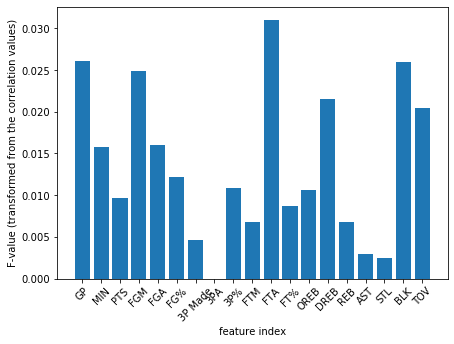

In [1026]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

df_clean_mod, df_clean_mod_test = select_features(df_fix_train, df_fix_test, labels)
X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_mod, target, scaler=StandardScaler(), resample='', random_state=random_state)

# feature selection
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')

# learn relationship from training data
f_selector.fit(X_train, y_train)

# transform train input data
X_train_fs = f_selector.transform(X_train)

# transform test input data
X_test_fs = f_selector.transform(X_test)

# Plot the scores for the features
plt.rcParams["figure.figsize"] = (7,5) 
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xticks(np.arange(len(labels)),labels=labels, rotation=45)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()

In [1027]:
rank_features('Feature ranking by MI Regression scores', labels, f_selector.scores_)[0:10]

Feature ranking by MI Regress scores


,feature,score
10,FTA,0.031043
0,GP,0.026103
17,BLK,0.025982
3,FGM,0.024905
13,DREB,0.021581
18,TOV,0.020433
4,FGA,0.016025
1,MIN,0.015727
5,FG%,0.012156
8,3P%,0.010817
